Brillyando Magathan Achmad - Adamata Take home test

Step by step:
1. Exploration data and label:
    Here, I want to see what kind of images, the labels, bounding boxes, classes, etc. Turns out that the label is not correctly assigned, so I want to solve this problem first. After doing some exploration, I decided to assign the label **manually** because by labeling using rule based (HSV mode), I found this was quite difficult since there are so many colors that affected by **value**. For example, in the file raw-250110_dc_s001_b4_3.jpg, the least error I can adjust were 2 errors using rule based (you can see further in the *assign the label using rule based section*).
    Since there are no explanation whether there could be different colors in the **same image**, which I thought it could before I made decision, thus for now I **implied** that there are **NO** different bottle cap colors in the **same image** until there's further explanation. Additional thing that strengthen my assumption is all the 'other' colors, such as in the raw-250110_dc_s001_b2_1.jpg and raw-250110_dc_s001_b3_3.jpg, is the **same** in the **same image**. 

    The manually adjusted label can be seen in the "relabel" directory, with train and val directory.

2. Address the lack of training image:
    Since the dataset only consists of 12 images, which is very low for training, I should do augmentation for data train. But, the additional question is, which library should I use to do the augmentation? Because I need to handle the bounding boxes too. So, I decided to use **Albumentation** library since it could handle the shift/movement of bounding boxes during augmentation.

3. Model Selection:
    As of now, the best model to do object detection and classification with fast inference time is YOLO series. The question is, which YOLO model should I use? 

    After doing some researches about the model type and model version of YOLO, here I used the **YOLOv9 tiny** because it has the smallest number of parameter, which is 2.0 M. But of course with the trade off - that is the lower accuracy compared to the newest one. Why I choose this model? Because the main objective is be able to run to edge device such as raspberry pi with **5-10 ms** inference time. 

    Yolov9 tiny is the most lightweight model in YOLO series and it'll suitable for raspberry pi to handle and do inference with faster time. Even though the small version of YOLO11 has 7-15 ms inference time in my own machine (laptop), but for raspberry pi **if** the model will run on it, then YOLOv9 tiny is the best choice.

4. Is this applicable to real world use case?
    The answer is **YES, IF THE TRAINING DATASET IS RICHER**. YOLO is powerful model. It can precisely detect and predict the desired object based on training and objective. Thus, to leverage that, the train and validation dataset has to be rich, general, clean, and varies.

    

    

In [ ]:
# download file

import requests, zipfile

zip_path = "../sample.zip"

url = "https://drive.usercontent.google.com/u/0/uc?id=1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT&export=download"
response = requests.get(url)

with open(f"{zip_path}", "wb") as f:
    f.write(response.content)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("../extracted")


: 

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print(cv2.__version__)

4.12.0


#### assign the label using rule based

First, I want to know the HSV from the raw images. Here I test one of them, which is the light blue bottle caps color.


In [62]:
import cv2
import numpy as np

img = cv2.imread("../sample/raw-250110_dc_s001_b4_1.jpg")
label = "../sample/raw-250110_dc_s001_b4_1.txt"

img_h, img_w = img.shape[:2]

with open(label, "r") as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    cls, x_center, y_center, bw, bh = map(float, line.split())

    xc = int(x_center * img_w)
    yc = int(y_center * img_h)
    bw = int(bw * img_w)
    bh = int(bh * img_h)

    x1 = int(xc - bw / 2)
    y1 = int(yc - bh / 2)
    x2 = int(xc + bw / 2)
    y2 = int(yc + bh / 2)

    crop = img[y1:y2, x1:x2]

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    h, s, v = np.mean(hsv[..., 0]), np.mean(hsv[..., 1]), np.mean(hsv[..., 2])

    print(f"[Box {i}] HSV avg =", (h, s, v))


[Box 0] HSV avg = (np.float64(88.68434343434343), np.float64(103.90633608815428), np.float64(83.19972451790633))
[Box 1] HSV avg = (np.float64(95.7806905370844), np.float64(77.59356351236147), np.float64(123.24104859335038))
[Box 2] HSV avg = (np.float64(95.4014053579271), np.float64(72.06302151954326), np.float64(106.12977602108037))
[Box 3] HSV avg = (np.float64(97.18774703557312), np.float64(81.22771190162494), np.float64(120.2659200702679))
[Box 4] HSV avg = (np.float64(90.42797540623627), np.float64(42.617259552042164), np.float64(86.42907334211682))


You can see that the minimum number of Hue is 88, thus I set the H_MIN into 88.0, with Value (V) threshold is 110. Now let's implement using other images.

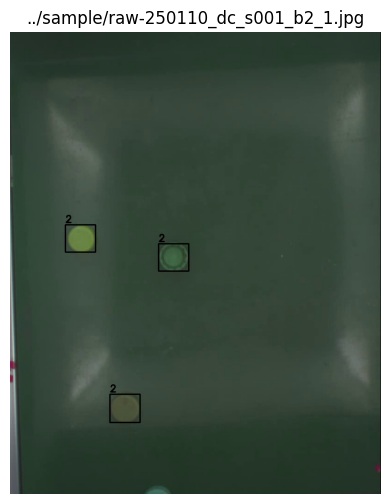

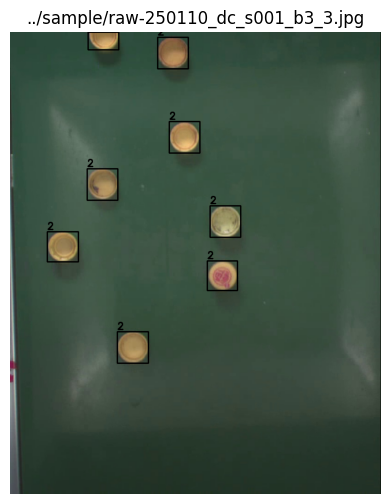

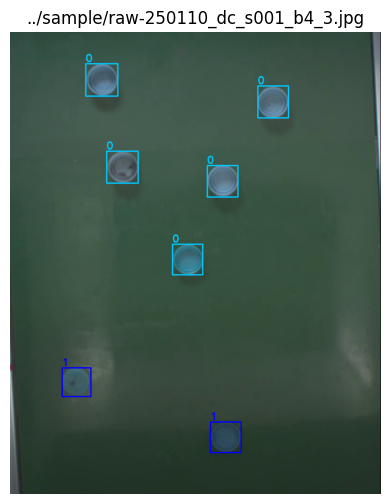

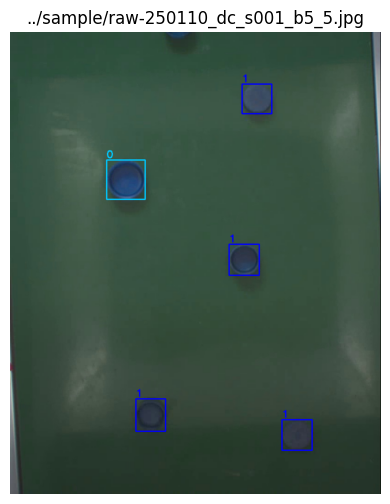

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_paths = [
    "../sample/raw-250110_dc_s001_b2_1.jpg",
    "../sample/raw-250110_dc_s001_b3_3.jpg",
    "../sample/raw-250110_dc_s001_b4_3.jpg",
    "../sample/raw-250110_dc_s001_b5_5.jpg"
]

label_paths = [
    "../sample/raw-250110_dc_s001_b2_1.txt",
    "../sample/raw-250110_dc_s001_b3_3.txt",
    "../sample/raw-250110_dc_s001_b4_3.txt",
    "../sample/raw-250110_dc_s001_b5_5.txt"
]

COLOR_MAP = {
    0: (255, 200, 0),   
    1: (255, 0, 0),     
    2: (0, 0, 0),       
}

# const of the hsv value
H_MIN = 88.0
H_MAX = 110.0
V_THRESHOLD = 95.0

for img_path, label_path in zip(img_paths, label_paths):

    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, xc_norm, yc_norm, bw_norm, bh_norm = map(float, line.split())

        # scale back from normalized value
        xc = int(xc_norm * img_w)
        yc = int(yc_norm * img_h)
        bw = int(bw_norm * img_w)
        bh = int(bh_norm * img_h)

        x1 = max(0, int(xc - bw / 2))
        y1 = max(0, int(yc - bh / 2))
        x2 = min(img_w, int(xc + bw / 2))
        y2 = min(img_h, int(yc + bh / 2))

        crop = img[y1:y2, x1:x2]

        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        h, s, v = np.mean(hsv[...,0]), np.mean(hsv[...,1]), np.mean(hsv[...,2])

        # rule based
        if H_MIN <= h <= H_MAX:
            if v > V_THRESHOLD:
                new_cls = 0 
            else:
                new_cls = 1
        else:
            new_cls = 2

        cv2.rectangle(img, (x1, y1), (x2, y2), COLOR_MAP[new_cls], 2)
        cv2.putText(img, str(new_cls), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, COLOR_MAP[new_cls], 2)

    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.title(img_path)
    plt.imshow(img_display)
    plt.axis("off")

plt.show()


You can see in the examples above, especially for pict 3 and 4, the rule based method assigns the wrong color. There are 2 dark blue colors in the pict 3, which those are just light blue but with bad lighting. Also for the image 4, there is 1 dark blue color (actual) that misclassify into light blue.

From this little example, I decided to assign the same color of the bottle caps in an image, in other words, 1 image has 1 class.

Pros:
1. Simple, since there's no further explanation
2. Fast convergence

Cons:
1. Model tends to overfit, because it "remembers" the image, not "generalize" the object
2. Not suitable for real world app/production, since the model couldn't see the big picture of the object.

# augmentation


In [6]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import albumentations as A

# ------------------------------
# CONFIG
# ------------------------------
INPUT_DIR = "../relabel"
OUTPUT_DIR = "../relabel_aug"

AUG_PER_IMAGE = 30
MOS_PER_IMAGE = 3  # Mosaic count per image

os.makedirs(OUTPUT_DIR, exist_ok=True)


# Albumentations pipeline (bbox-safe)
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.4),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.Blur(blur_limit=3, p=0.2),
        # A.ColorJitter(p=0.4),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)


# ------------------------------
# Helper: Read YOLO labels
# ------------------------------
def read_yolo_label(label_path):
    bboxes = []
    classes = []
    if not os.path.exists(label_path):
        return bboxes, classes

    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, xc, yc, w, h = line.strip().split()
            bboxes.append([float(xc), float(yc), float(w), float(h)])
            classes.append(int(cls))
    return bboxes, classes


# ------------------------------
# Helper: Write YOLO labels
# ------------------------------
def write_yolo_label(label_path, bboxes, classes):
    with open(label_path, "w") as f:
        for cls, bb in zip(classes, bboxes):
            f.write(f"{cls} {bb[0]:.6f} {bb[1]:.6f} {bb[2]:.6f} {bb[3]:.6f}\n")

# ------------------------------
# MAIN AUG PIPELINE
# ------------------------------
for split in ["train"]:
    img_dir = os.path.join(INPUT_DIR, split, "images")
    lbl_dir = os.path.join(INPUT_DIR, split, "labels")

    out_img_dir = os.path.join(OUTPUT_DIR, split, "images")
    out_lbl_dir = os.path.join(OUTPUT_DIR, split, "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    images = sorted(os.listdir(img_dir))

    for img_file in tqdm(images, desc=f"Augmenting {split}"):
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(lbl_dir, img_file.replace(".jpg", ".txt"))

        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        bboxes, classes = read_yolo_label(label_path)

        # perform 30 single-image augmentations
        for i in range(AUG_PER_IMAGE):
            aug = transform(image=image, bboxes=bboxes, class_labels=classes)
            aug_img = aug['image']
            aug_bboxes = aug['bboxes']
            aug_classes = aug['class_labels']

            out_name = img_file.replace(".jpg", f"_aug{i}.jpg")

            cv2.imwrite(os.path.join(out_img_dir, out_name), aug_img)
            write_yolo_label(os.path.join(out_lbl_dir, out_name.replace(".jpg", ".txt")),
                             aug_bboxes, aug_classes)

print("DONE!")


Augmenting train: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

DONE!


# Inference


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\image.jpg: 640x640 5 light_blues, 23.9ms
Speed: 3.6ms preprocess, 23.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


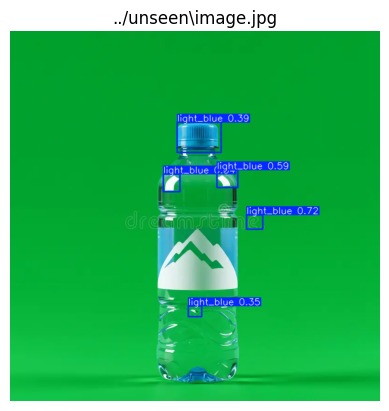


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\raw-250110_dc_s001_b2_1_aug5.jpg: 640x544 4 otherss, 23.6ms
Speed: 4.3ms preprocess, 23.6ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 544)


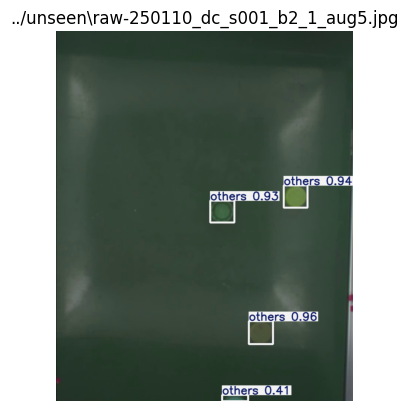


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\raw-250110_dc_s001_b2_3_aug23.jpg: 640x544 7 otherss, 17.8ms
Speed: 3.3ms preprocess, 17.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 544)


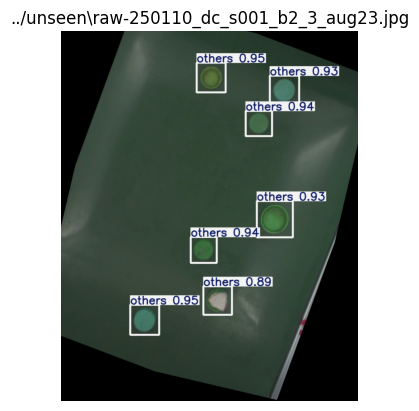


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\raw-250110_dc_s001_b3_2_aug14.jpg: 640x544 9 otherss, 17.7ms
Speed: 3.2ms preprocess, 17.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 544)


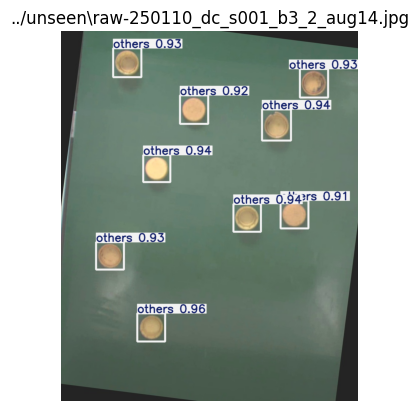


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\raw-250110_dc_s001_b4_1_aug18.jpg: 640x544 5 light_blues, 17.7ms
Speed: 5.1ms preprocess, 17.7ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 544)


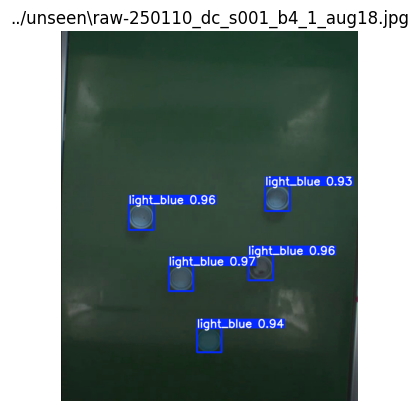


image 1/1 d:\RL backup\Projects\caps_color_detection\exploration\..\unseen\raw-250110_dc_s001_b5_3_aug29.jpg: 640x544 7 dark_blues, 17.7ms
Speed: 3.7ms preprocess, 17.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 544)


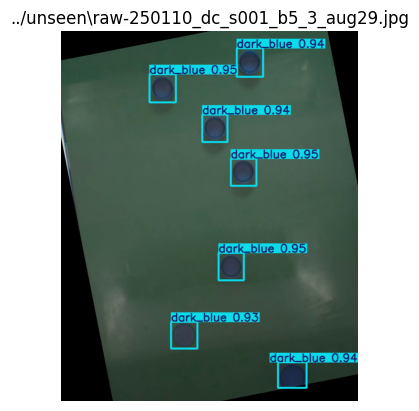

In [8]:
from ultralytics import YOLO
import cv2, glob
import matplotlib.pyplot as plt

model = YOLO("../runs/detect/train/weights/best.pt")

image_paths = glob.glob("../unseen/*.jpg")

for path in image_paths:
    result = model(path)[0]  # run inference
    img = result.plot()      # draw bboxes

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.title(path)
    plt.axis("off")
    plt.show()
